In [1]:
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
map_base_dir = 'D:/Segmentation of rooftops'
map_img_dir = 'D:/Segmentation of rooftops/images'

In [2]:
json_path = os.path.join(map_base_dir, 'annotation-small.json')
with open(json_path, 'r') as f:
    annot_data = json.load(f)

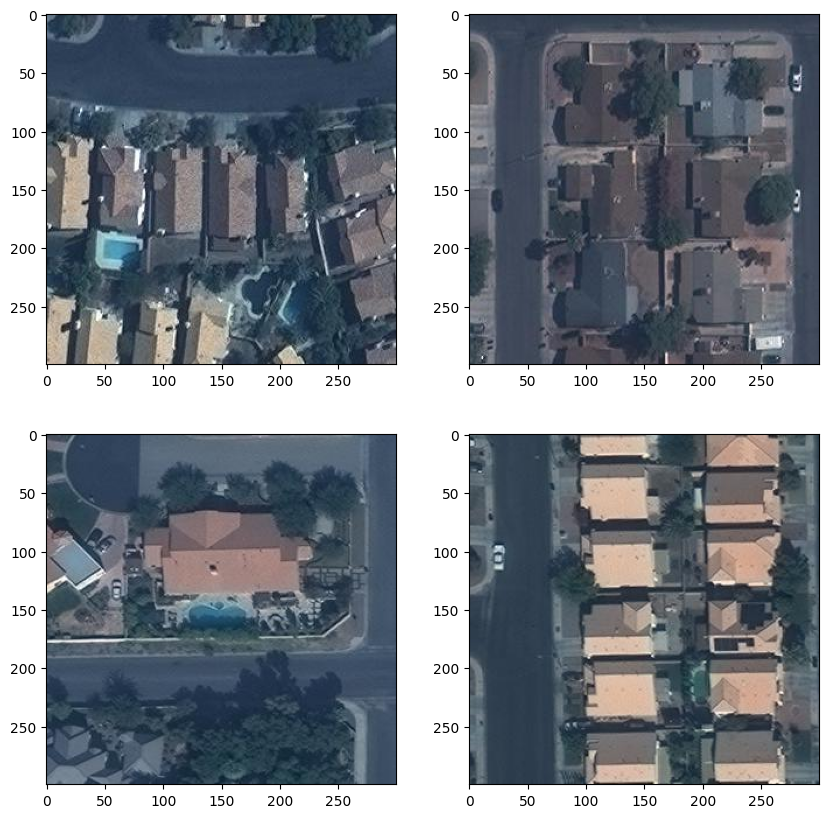

In [3]:
image_df = pd.DataFrame(annot_data['images'])
image_df.sample(3)
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)


In [4]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(3)

id  image_id                                       segmentation  \
23899  2326652    272699  [[293.0, 208.0, 300.0, 208.0, 300.0, 269.0, 29...   
18233  1133147    133024  [[154, 213, 154, 237, 127, 237, 126, 262, 92, ...   
40081  1637200    192004  [[216.00000000000003, 300.0, 216.0000000000000...   

         area                                     bbox  category_id  iscrowd  
23899   407.0                [208.0, 293.0, 92.0, 7.0]          100        0  
18233  3283.0                        [58, 58, 204, 96]          100        0  
40081  1557.0  [209.0, 209.0, 91.0, 35.00000000000003]          100        0

In [5]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(2)


8366 + 71871 -> 71871


id_x  image_id                                       segmentation  \
4279   488912     57305  [[88.0, 268.0, 105.0, 268.0, 105.0, 260.0, 119...   
66456  328348     38470  [[0.0, 73.99999999999999, 16.0, 75.99999999999...   

         area                                 bbox  category_id  iscrowd  \
4279   2210.0            [88.0, 88.0, 180.0, 68.0]          100        0   
66456  1500.0  [0.0, 0.0, 90.99999999999999, 24.0]          100        0   

        id_y         file_name  width  height  
4279   57305  000000057305.jpg    300     300  
66456  38470  000000038470.jpg    300     300

In [6]:
def create_boxes(in_rows):
    #TODO: this seems to get a few of the boxes wrong so we stick to segmentation polygons instead
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox from the coco standard
        (start_y, start_x, wid_y, wid_x) = in_row['bbox']
        
        box_list += [Rectangle((start_x, start_y), 
                         wid_y , wid_x
                         )]
    return box_list

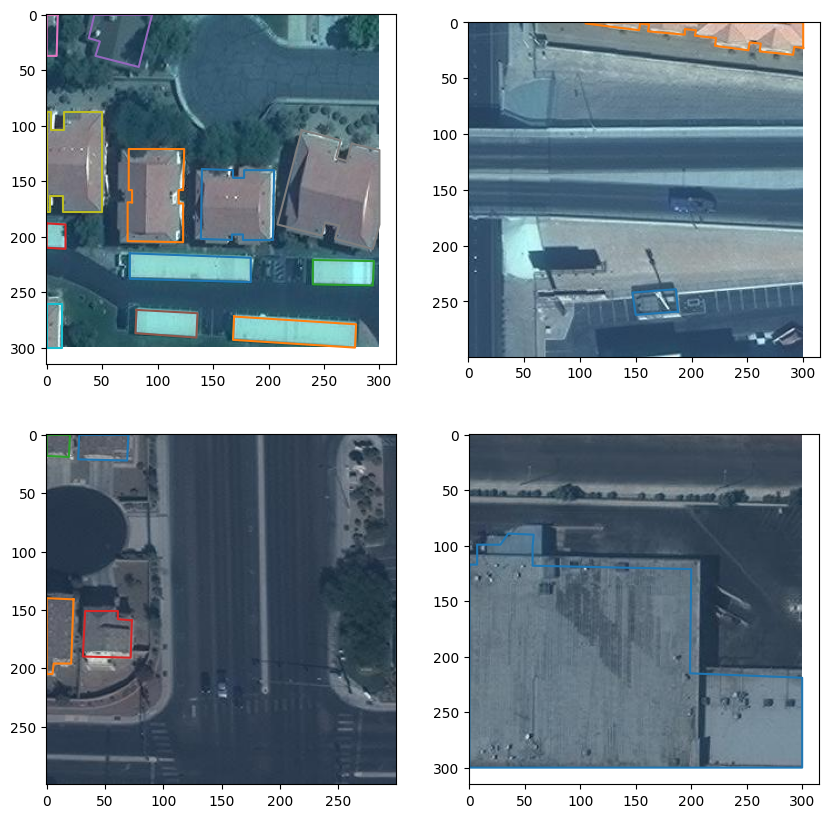

In [7]:
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    #c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        xy_vec.astype(dtype = object)
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

In [8]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

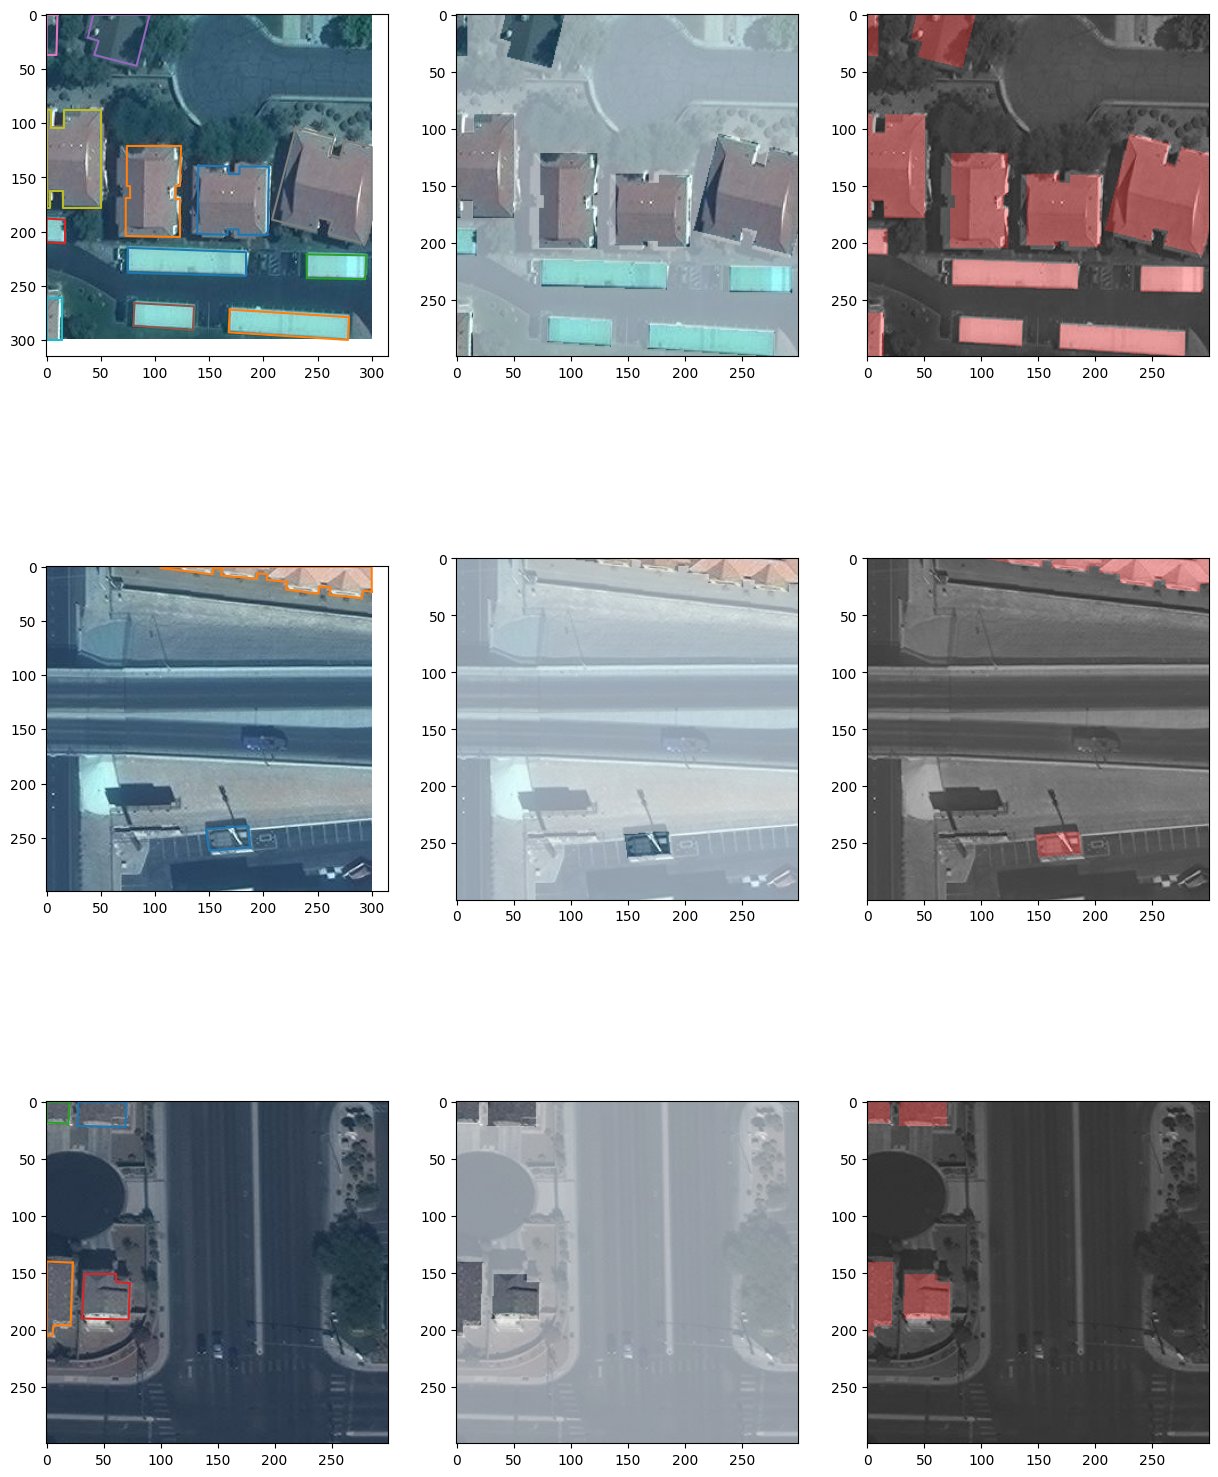

In [9]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data, 
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)
    
    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))

In [10]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

54005 training boxes
17866 validation boxes


In [11]:
def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img)>=batch_size:
                yield (np.stack(out_img, 0)/255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []
valid_gen = batch_img_gen(valid_df, 8)

C:\Users\Ruishabh Rijhwani\AppData\Local\Temp\ipykernel_23072\3766723584.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


x (8, 300, 300, 3) float32 0.0 1.0
y (8, 300, 300, 1) float32 0.0 1.0


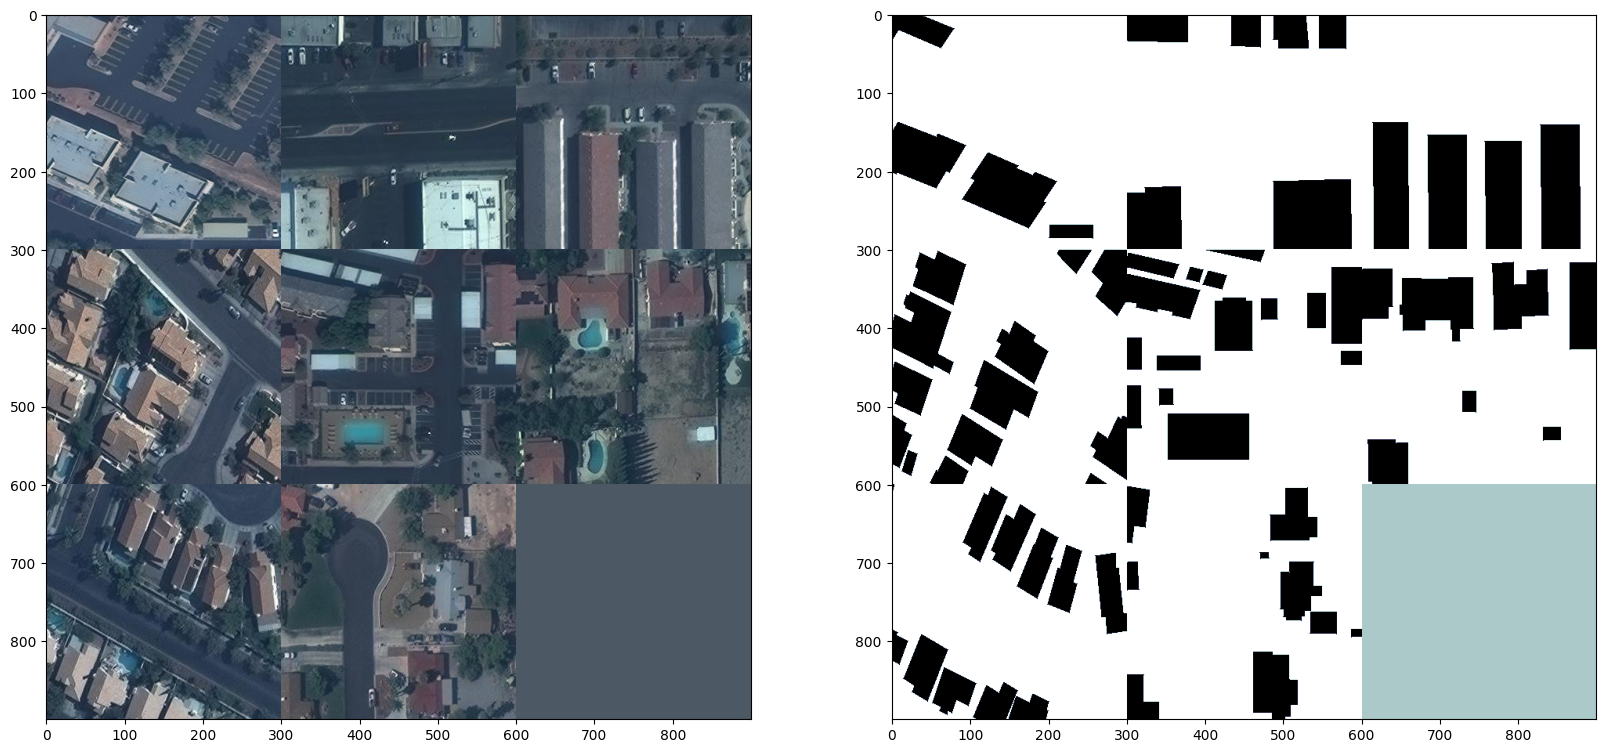

In [12]:
from skimage.util import montage as montage2d
t_x, t_y = next(valid_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')

In [13]:
import tensorflow as tf
import datetime, os

logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

UsageError: Line magic function `%tensorboard` not found.


In [24]:
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1852), started 3:44:49 ago. (Use '!kill 1852' to kill it.)

In [15]:
BLOCK_COUNT = 1
EDGE_CROP = 16
BASE_DEPTH = 16
SPATIAL_DROPOUT = 0.25
GAUSSIAN_NOISE = 0.1
BATCH_SIZE = 24

In [16]:
from keras import models, layers
def conv_bn(x, filt, dl_rate=(1,1), preblock = False):
    y = layers.Convolution2D(filt, (3, 3), 
                             activation='linear', 
                             padding='same', 
                             dilation_rate=dl_rate,
                            use_bias=False)(x)
    if preblock: return y
    y = layers.BatchNormalization()(y)
    return layers.Activation('elu')(y)

in_layer = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c = conv_bn(pp_in_layer, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH)

skip_layers = [pp_in_layer]
for j in range(BLOCK_COUNT):
    depth_steps = int(np.log2(t_x.shape[1])-2)
    d = layers.concatenate(skip_layers+[conv_bn(c, BASE_DEPTH*2**j, (2**i, 2**i), preblock=True) 
                                        for i in range(depth_steps)])
    d = layers.SpatialDropout2D(SPATIAL_DROPOUT)(d)
    d = layers.BatchNormalization()(d)
    d = layers.Activation('elu')(d)
    # bottleneck
    d = conv_bn(d, BASE_DEPTH*2**(j+1))
    skip_layers += [c]
    c = d
d = layers.Convolution2D(1, (1, 1), activation='ReLU', padding='same')(d)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
seg_model = models.Model(inputs = [in_layer],
                    outputs = [d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 300, 300, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 300, 300, 3)  12          gaussian_noise[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 300, 300, 8)  216         batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.05*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [22]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [23]:
valid_gen = batch_img_gen(valid_df, BATCH_SIZE)
loss_history = [seg_model.fit(batch_img_gen(train_df, BATCH_SIZE), 
                             steps_per_epoch=min(train_ids.shape[0]//BATCH_SIZE, 100),
                             epochs=30, 
                             validation_data = valid_gen,
                             validation_steps = min(train_ids.shape[0]//BATCH_SIZE, 50),
                             callbacks=callbacks_list,
                            workers=1)]

C:\Users\Ruishabh Rijhwani\AppData\Local\Temp\ipykernel_23072\3766723584.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: -0.5545 - dice_coef: 0.7432 - binary_accuracy: 0.7176 - true_positive_rate: 2.5377

C:\Users\Ruishabh Rijhwani\AppData\Local\Temp\ipykernel_23072\3766723584.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for (_, c_df) in np.random.permutation(all_groups):


100/100 [==============================] - 322s 3s/step - loss: -0.5545 - dice_coef: 0.7432 - binary_accuracy: 0.7176 - true_positive_rate: 2.5377 - val_loss: -0.3554 - val_dice_coef: 0.6961 - val_binary_accuracy: 0.5059 - val_true_positive_rate: 3.9802

Epoch 00001: val_dice_coef improved from -inf to 0.69611, saving model to seg_model_weights.best.hdf5
Epoch 2/30
100/100 [==============================] - 302s 3s/step - loss: -0.7293 - dice_coef: 0.9094 - binary_accuracy: 0.7472 - true_positive_rate: 4.0305 - val_loss: -0.7026 - val_dice_coef: 0.9038 - val_binary_accuracy: 0.7180 - val_true_positive_rate: 4.5002

Epoch 00002: val_dice_coef improved from 0.69611 to 0.90377, saving model to seg_model_weights.best.hdf5
Epoch 3/30
100/100 [==============================] - 293s 3s/step - loss: -0.7662 - dice_coef: 0.9410 - binary_accuracy: 0.7561 - true_positive_rate: 4.3200 - val_loss: -0.7936 - val_dice_coef: 0.9741 - val_binary_accuracy: 0.7518 - val_true_positive_rate: 5.3986

Epoch 

In [20]:
seg_model.load_weights(weight_path)
seg_model.save('full_best_model.h5')

x (16, 300, 300, 3) float32 0.0 1.0
y (16, 300, 300, 1) float32 0.0 1.0
1/1 [==============================] - 3s 3s/step


Text(0.5, 1.0, 'Prediction')

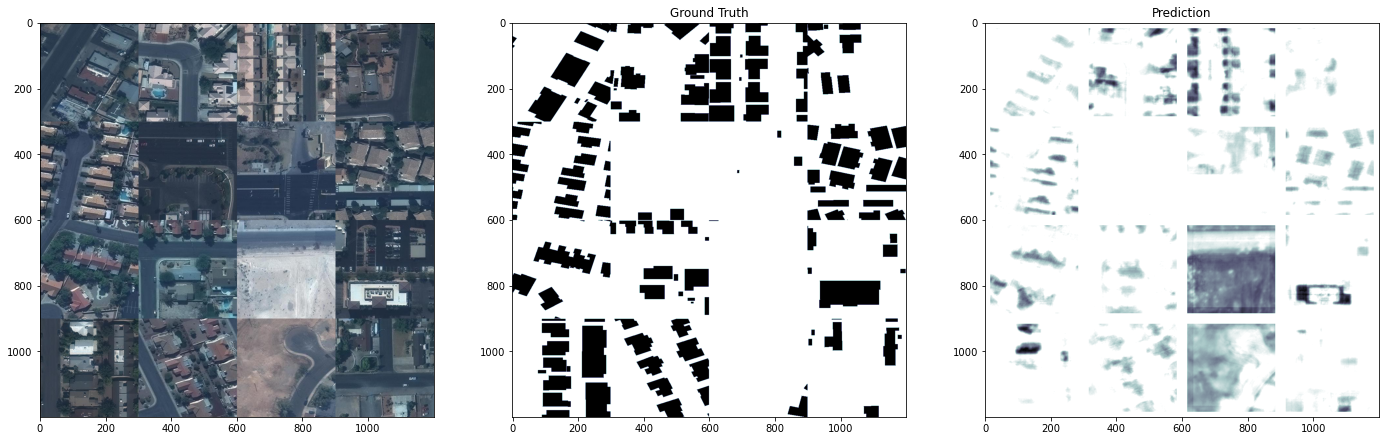

In [22]:
t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]
    
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')


In [1]:
import tensorflow as tf
import datetime, os

logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

UsageError: Line magic function `%tensorboard` not found.


In [2]:
%load_ext tensorboard


In [4]:
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt



def create_segmentation(img):
	gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
	ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU) #+cv.THRESH_OTSU

	# noise removal
	kernel = np.ones((3,3),np.uint8)
	opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 1)

	# sure background area
	sure_bg = cv.dilate(opening,kernel,iterations=7)

	# Finding sure foreground area
	dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
	ret, sure_fg = cv.threshold(dist_transform,0.05*dist_transform.max(),255,0)

	# Finding unknown region
	sure_fg = np.uint8(sure_fg)
	unknown = cv.subtract(sure_bg,sure_fg)

	# inverse the pixel values
	unknown2 = 255 - unknown

	return(unknown2)


def create_contours(img, segmented_img):

	_, contours, _ = cv.findContours(segmented_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

	for cont in contours:
	    
	    # epsilon is the maximum distance between the contour and the approximated contour
	    # epsilon = error_rate * actual_arc_length
	    
	    epsilon = 0.01 * cv.arcLength(cont, True)
	    
	    # use approxPolyDP to approximate the polygon
	    approx = cv.approxPolyDP(cont, epsilon, True)
	    
	    # img2 = cv.drawContours(img2, [approx], 0, (0,0,255), 3)

	    centre = (img.shape[0]/2, img.shape[1]/2)

	valid_contours = []

	for cont in contours:

	    dist = cv.pointPolygonTest(cont,centre,False)
	    if  dist != -1:
	        valid_contours += [cont]

	print("{} contour(s) found".format(len(valid_contours)))

	return(valid_contours)


def calc_surface(img, contours):

	if bool(contours) is False: 
		raise ValueError("No contours")

	if len(contours) > 1: 
		raise ValueError("More than one contours passed")
	
	surface = cv.contourArea(contours[0])
	
	surface = surface / (img.shape[0] * img.shape[1])

	return(surface)


def predict(img):

	val = create_segmentation(img)

	val = create_contours(img, val)

	val = calc_surface(img, val)

	return(val)


if __name__ == "__main__":

	path = "./sample_images/image3.png"

	img = cv.imread(path)

	print(predict(img))